# Pyspark Installation And Imports

In [9]:
!pip install --upgrade pip

  Using cached pip-22.2.2-py3-none-any.whl (2.0 MB)
  Attempting uninstall: pip
    Found existing installation: pip 21.1.2
    Uninstalling pip-21.1.2:
      Successfully uninstalled pip-21.1.2


ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\uriah\\AppData\\Local\\Temp\\pip-uninstall-mjg7ffdd\\pip.exe'
Check the permissions.



In [8]:
!pip install findspark
!pip install pyspark

In [4]:
import findspark
findspark.init()
from pyspark.sql import SparkSession

def init_spark(app_name: str):
    spark = SparkSession.builder.appName(app_name).getOrCreate()
    sc = spark.sparkContext
    return spark, sc

spark, sc = init_spark('Distributed_Theaters')
sc

<SparkContext master=local[*] appName=Distributed_Theaters>

In [5]:
import pyspark.sql.functions as f

# Loading The Static Data

In [4]:
data = spark.read.json('/content/data.json')
data.printSchema()
data.show(5, truncate=False)
print(f"Loaded {data.count()} Rows and {len(data.columns)} Columns.")

root
 |-- Arrival_Time: long (nullable = true)
 |-- Creation_Time: long (nullable = true)
 |-- Device: string (nullable = true)
 |-- Index: long (nullable = true)
 |-- Model: string (nullable = true)
 |-- User: string (nullable = true)
 |-- gt: string (nullable = true)
 |-- x: double (nullable = true)
 |-- y: double (nullable = true)
 |-- z: double (nullable = true)

+-------------+-------------------+--------+-----+------+----+-----+-------------+------------+-------------+
|Arrival_Time |Creation_Time      |Device  |Index|Model |User|gt   |x            |y           |z            |
+-------------+-------------------+--------+-----+------+----+-----+-------------+------------+-------------+
|1424686735175|1424686733176178965|nexus4_1|35   |nexus4|g   |stand|0.0014038086 |5.0354E-4   |-0.0124053955|
|1424686735378|1424686733382813486|nexus4_1|76   |nexus4|g   |stand|-0.0039367676|0.026138306 |-0.01133728  |
|1424686735577|1424686733579072031|nexus4_1|115  |nexus4|g   |stand|0.003540039 

# Exploratory Data Analysis - Data Format and Transformations

Let's see how many different values exist in each of our datas' attributes.

In [5]:
for col in data.columns:
    col_count = data.select(col).distinct().count()
    print(f"{col} Column: {col_count} Unique Values")

Arrival_Time Column: 458566 Unique Values
Creation_Time Column: 546083 Unique Values
Device Column: 2 Unique Values
Index Column: 290800 Unique Values
Model Column: 1 Unique Values
User Column: 9 Unique Values
gt Column: 7 Unique Values
x Column: 39936 Unique Values
y Column: 45791 Unique Values
z Column: 50931 Unique Values


It seems that there is only 1 type of model given in our dataset, and therefore we can't use it to classify our data, so we should drop this column from our data.

In [6]:
data.where(~f.col("Device").contains("nexus4_")).count()

0

Furtheremore, as was explained in the projects' instructions, the 'Device' column values start with the device's model, followed by the device's number.

As we saw before, the only model in our dataset is Nexus 4, and thus all the device prefixes are the same, i.e. 'nexus4_'. Therefore, we can remove this prefix and leave only the numeric part.

In [7]:
data = data.withColumn("Device", f.expr("regexp_replace(regexp_replace(Device, Model, ''), '_', '')").cast("int")).drop("Model")

In [8]:
data.printSchema()
data.show(5)

root
 |-- Arrival_Time: long (nullable = true)
 |-- Creation_Time: long (nullable = true)
 |-- Device: integer (nullable = true)
 |-- Index: long (nullable = true)
 |-- User: string (nullable = true)
 |-- gt: string (nullable = true)
 |-- x: double (nullable = true)
 |-- y: double (nullable = true)
 |-- z: double (nullable = true)

+-------------+-------------------+------+-----+----+-----+-------------+------------+-------------+
| Arrival_Time|      Creation_Time|Device|Index|User|   gt|            x|           y|            z|
+-------------+-------------------+------+-----+----+-----+-------------+------------+-------------+
|1424686735175|1424686733176178965|     1|   35|   g|stand| 0.0014038086|   5.0354E-4|-0.0124053955|
|1424686735378|1424686733382813486|     1|   76|   g|stand|-0.0039367676| 0.026138306|  -0.01133728|
|1424686735577|1424686733579072031|     1|  115|   g|stand|  0.003540039|-0.034744263| -0.019882202|
|1424686735779|1424688581834321412|     2|  163|   g|stand| 

In [9]:
data.withColumn("Arrival_Time", f.to_timestamp(f.from_unixtime(f.col("Arrival_Time") / 1e3))) \
    .withColumn("Creation_Time", f.to_timestamp(f.from_unixtime(f.col("Creation_Time") / 1e9))) \
    .show(5, truncate=False)

+-------------------+-------------------+------+-----+----+-----+-------------+------------+-------------+
|Arrival_Time       |Creation_Time      |Device|Index|User|gt   |x            |y           |z            |
+-------------------+-------------------+------+-----+----+-----+-------------+------------+-------------+
|2015-02-23 10:18:55|2015-02-23 10:18:53|1     |35   |g   |stand|0.0014038086 |5.0354E-4   |-0.0124053955|
|2015-02-23 10:18:55|2015-02-23 10:18:53|1     |76   |g   |stand|-0.0039367676|0.026138306 |-0.01133728  |
|2015-02-23 10:18:55|2015-02-23 10:18:53|1     |115  |g   |stand|0.003540039  |-0.034744263|-0.019882202 |
|2015-02-23 10:18:55|2015-02-23 10:49:41|2     |163  |g   |stand|0.002822876  |0.005584717 |0.017318726  |
|2015-02-23 10:18:55|2015-02-23 10:49:42|2     |203  |g   |stand|0.0017547607 |-0.018981934|-0.022201538 |
+-------------------+-------------------+------+-----+----+-----+-------------+------------+-------------+
only showing top 5 rows



In [10]:
data.withColumn("Arrival_Time", f.unix_timestamp(f.col("Arrival_Time"))) \
    .withColumn("Creation_Time", f.unix_timestamp(f.col("Creation_Time"))) \
    .show()

AnalysisException: ignored

# Exploratory Data Analysis - Descriptive Statistics Of The Data

In [ ]:
data.summary().show()

+-------+--------------------+--------------------+-------------------+------------------+------+------+--------------------+--------------------+--------------------+
|summary|        Arrival_Time|       Creation_Time|             Device|             Index|  User|    gt|                   x|                   y|                   z|
+-------+--------------------+--------------------+-------------------+------------------+------+------+--------------------+--------------------+--------------------+
|  count|              546083|              546083|             546083|            546083|546083|546083|              546083|              546083|              546083|
|   mean|1.424745913493358...|1.424746844280259...|  1.504392189465704|174532.39364345712|  null|  null|0.001194576343112...|-0.00611744865834...|-0.00859196071117771|
| stddev| 4.371781991410818E7|4.372979507049822E13|0.49998116608835624| 102083.3955022451|  null|  null|  0.4520729422637063|  0.4611932946202158|  0.5235818108

## Spatial Insights

In [11]:
spatial_columns = ["x", "y", "z"]

In [12]:
data.groupby("User", "gt").agg(*[f.count(col) for col in spatial_columns],
                               *[f.sum(col) for col in spatial_columns],
                               *[f.avg(col) for col in spatial_columns],
                               *[f.min(col) for col in spatial_columns],
                               *[f.max(col) for col in spatial_columns]) \
                               .sort("User", "gt") \
                               .show()

+----+----------+--------+--------+--------+-------------------+-------------------+-------------------+--------------------+--------------------+--------------------+-----------+-----------+-----------+-----------+----------+----------+
|User|        gt|count(x)|count(y)|count(z)|             sum(x)|             sum(y)|             sum(z)|              avg(x)|              avg(y)|              avg(z)|     min(x)|     min(y)|     min(z)|     max(x)|    max(y)|    max(z)|
+----+----------+--------+--------+--------+-------------------+-------------------+-------------------+--------------------+--------------------+--------------------+-----------+-----------+-----------+-----------+----------+----------+
|   a|      bike|    7014|    7014|    7014|  584.0694430351006|    -161.1789090139| -1141.190338100301| 0.08327194796622478|-0.02297959923209296| -0.1627017875820218|  -0.789032| -1.2349548| -1.2032776|  0.7725525|0.96429443| 1.5591431|
|   a|      null|    5726|    5726|    5726|-117

In [13]:
data.withColumn("norm", (sum([data[col] ** 2
                        for col in spatial_columns]))**0.5).show()

+-------------+-------------------+------+-----+----+-----+-------------+-------------+-------------+--------------------+
| Arrival_Time|      Creation_Time|Device|Index|User|   gt|            x|            y|            z|                norm|
+-------------+-------------------+------+-----+----+-----+-------------+-------------+-------------+--------------------+
|1424686735175|1424686733176178965|     1|   35|   g|stand| 0.0014038086|    5.0354E-4|-0.0124053955|0.012494721630690864|
|1424686735378|1424686733382813486|     1|   76|   g|stand|-0.0039367676|  0.026138306|  -0.01133728| 0.02876183404243279|
|1424686735577|1424686733579072031|     1|  115|   g|stand|  0.003540039| -0.034744263| -0.019882202| 0.04018703328069259|
|1424686735779|1424688581834321412|     2|  163|   g|stand|  0.002822876|  0.005584717|  0.017318726|0.018414558456409998|
|1424686735982|1424688582035859498|     2|  203|   g|stand| 0.0017547607| -0.018981934| -0.022201538|0.029262626216046715|
|1424686736186|1

TypeError: ignored

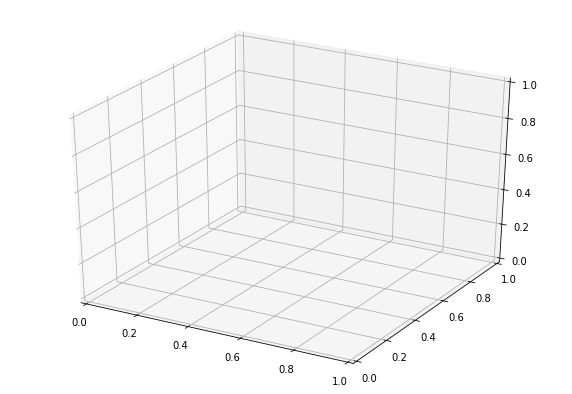

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

points_columns = [*spatial_columns, "gt"]
points = [[r[col] 
           for col in points_columns] 
          for r in data.select(*points_columns).collect()]

points = [[points[i][j] 
           for i in range(len(points))] 
          for j in range(len(points[0]))]

gt_dict = dict([(y, x + 1) for x, y in enumerate(sorted(set(points[-1])))])
points[-1] = [gt_dict[x] for x in points[-1]]

fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection="3d")

for gt in gt_dict.items():
    ax.scatter3D(*points[points[-1]==gt[1]][:-1], s=20, label=gt[0])

plt.legend(loc="upper right")
plt.show()

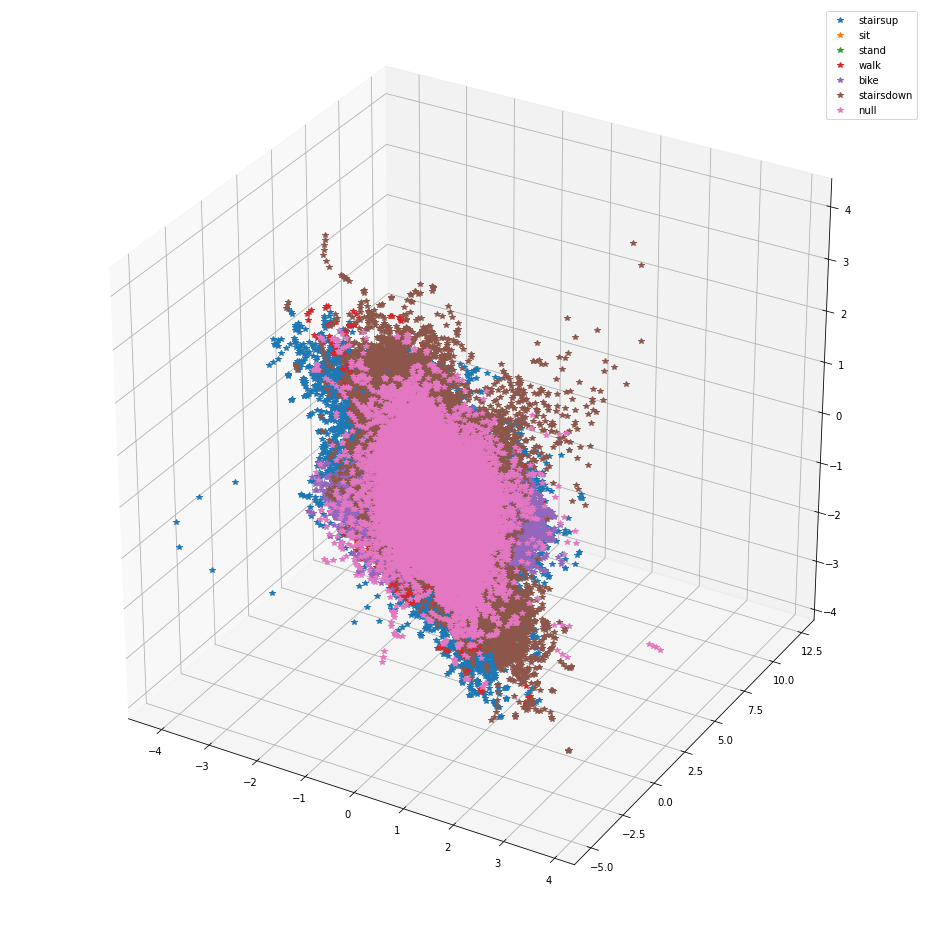

In [22]:
#from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt

points_columns = [*spatial_columns, "gt"]
points = [[r[col] 
           for col in points_columns] 
          for r in data.select(*points_columns).collect()]
labeled_points = {activity["gt"]:[[],[],[]] for activity in data.select("gt").distinct().collect()}
#print(labeled_points)
for point in points:
  labeled_points[point[3]][0].append(point[0])
  labeled_points[point[3]][1].append(point[1])
  labeled_points[point[3]][2].append(point[2])

# points = [[points[i][j] 
#            for i in range(len(points))] 
#           for j in range(len(points[0]))]
plt.rcParams["figure.figsize"] = [13.0, 13.0]
plt.rcParams["figure.autolayout"] = True

axes = plt.subplot(111, projection='3d')
for key, value in labeled_points.items():
  axes.plot(labeled_points[key][0], labeled_points[key][1], labeled_points[key][2],"*", label=key)
plt.legend(loc="upper right")

plt.show()

In [32]:
points_columns = [*spatial_columns, "gt"]
points = [[r[col] 
           for col in points_columns] 
          for r in data.select(*points_columns).collect()]
labeled_points = {activity["gt"]:[[],[],[]] for activity in data.select("gt").distinct().collect()}

for point in points:
  labeled_points[point[3]][0].append(point[0])
  labeled_points[point[3]][1].append(point[1])
  labeled_points[point[3]][2].append(point[2])

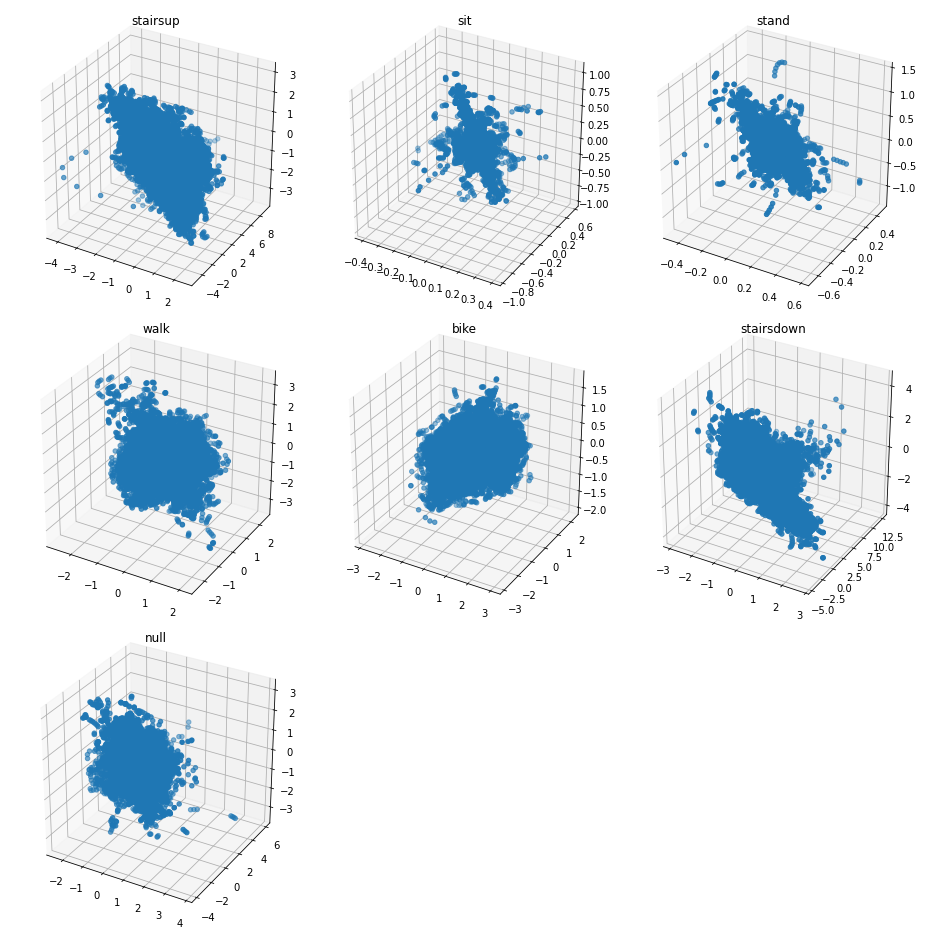

In [33]:
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt

# points_columns = [*spatial_columns, "gt"]
# points = [[r[col] 
#            for col in points_columns] 
#           for r in data.select(*points_columns).collect()]
# labeled_points = {activity["gt"]:[[],[],[]] for activity in data.select("gt").distinct().collect()}
# #print(labeled_points)
# for point in points:
#   labeled_points[point[3]][0].append(point[0])
#   labeled_points[point[3]][1].append(point[1])
#   labeled_points[point[3]][2].append(point[2])

fig = plt.figure()
ax_dict = dict()
for i in range(len(labeled_points)):
  ax_dict["ax_{0}".format(i)]= fig.add_subplot(330+i+1,projection='3d')

lp_keys = list(labeled_points.keys())
c=0
for key, value in ax_dict.items():
  k = lp_keys[c]
  ax_dict[key].scatter(labeled_points[k][0], labeled_points[k][1], labeled_points[k][2])
  ax_dict[key].set_title(k)
  c+=1

# points = [[points[i][j] 
#            for i in range(len(points))] 
#           for j in range(len(points[0]))]
# plt.rcParams["figure.figsize"] = [13.0, 13.0]
# plt.rcParams["figure.autolayout"] = True

# axes = plt.subplot(111, projection='3d')
# for key, value in labeled_points.items():
#   axes.plot(labeled_points[key][0], labeled_points[key][1], labeled_points[key][2],"*", label=key)
# plt.legend(loc="upper right")

plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True

N = 100

x = np.random.rand(N)
y = np.random.rand(N)

z1 = [i*j for (i, j) in zip(x, y)]
z2 = [i+j for (i, j) in zip(x, y)]

axes = plt.subplot(111, projection='3d')

axes.plot(x, y, z1, "*", label="xy")
axes.plot(x, y, z2, "o", label="x+y")

plt.legend(loc="upper right")

plt.show()

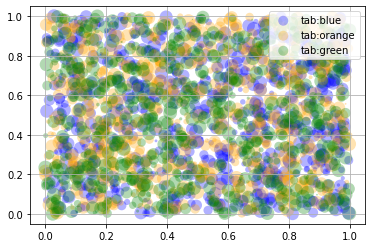

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(19680801)


fig, ax = plt.subplots()
for color in ['tab:blue', 'tab:orange', 'tab:green']:
    n = 750
    x, y = np.random.rand(2, n)
    scale = 200.0 * np.random.rand(n)
    ax.scatter(x, y, c=color[4:], s=scale, label=color,
               alpha=0.3, edgecolors='none')

ax.legend()
ax.grid(True)

plt.show()

## Temporal Insights

In [ ]:
data.groupby("User", "Device", "gt").min("Creation_Time").sort("User").show()

+----+------+----------+-------------------+
|User|Device|        gt| min(Creation_Time)|
+----+------+----------+-------------------+
|   a|     2|      bike|1424700063782555432|
|   a|     1|      walk|1424697360563438418|
|   a|     2|     stand|1424698480066408835|
|   a|     1|  stairsup|1424697663384881527|
|   a|     1|     stand|1424565700120513176|
|   a|     1|stairsdown|1424697672398810690|
|   a|     1|      bike|1424698215737244422|
|   a|     1|       sit|1424696943173036149|
|   a|     2|      null|1424698780366085160|
|   a|     2|       sit|1424698793112733406|
|   a|     1|      null|1424696935373871704|
|   a|     2|  stairsup|1424699507161408114|
|   a|     2|stairsdown|1424699520458136328|
|   a|     2|      walk|1424699208607697730|
|   b|     2|stairsdown|1424787640854211650|
|   b|     2|       sit|1424786820027008700|
|   b|     1|      walk|1424785396668741254|
|   b|     1|     stand|1424784654234888470|
|   b|     1|      null|1424784972089038312|
|   b|    

In [ ]:
data.groupby("Index").count().where(f.col("count") > 1).sort("index").show()

+-----+-----+
|Index|count|
+-----+-----+
|    5|    2|
|    6|    2|
|    7|    3|
|    8|    3|
|    9|    2|
|   10|    2|
|   19|    2|
|   20|    3|
|   21|    2|
|   22|    3|
|   23|    3|
|   24|    2|
|   26|    2|
|   28|    2|
|   29|    2|
|   30|    2|
|   34|    2|
|   35|    4|
|   36|    3|
|   37|    4|
+-----+-----+
only showing top 20 rows



In [ ]:
data.where(data["Index"] == 5).show()

+-------------+-------------------+--------+-----+------+----+-----+------------+------------+-------------+
| Arrival_Time|      Creation_Time|  Device|Index| Model|User|   gt|           x|           y|            z|
+-------------+-------------------+--------+-----+------+----+-----+------------+------------+-------------+
|1424787189363|1424787192831464936|nexus4_1|    5|nexus4|   e|stand| -7.62939E-5|-0.012863159|-0.0059051514|
|1424686734992|1424688581040070924|nexus4_2|    5|nexus4|   g|stand|-3.814697E-4| 0.025878906|  0.023727417|
+-------------+-------------------+--------+-----+------+----+-----+------------+------------+-------------+



In [ ]:
data.join(data, on=["Creation_Time"]).count()

546083

In [ ]:
data.where(f.col("gt") == "null").show()

+-------------+-------------------+--------+-----+------+----+----+-------------+-------------+-------------+
| Arrival_Time|      Creation_Time|  Device|Index| Model|User|  gt|            x|            y|            z|
+-------------+-------------------+--------+-----+------+----+----+-------------+-------------+-------------+
|1424687076944|1424687074952779813|nexus4_1|53092|nexus4|   g|null| 0.0014038086|    5.0354E-4|-0.0038604736|
|1424687077146|1424688923198146253|nexus4_2|52626|nexus4|   g|null|  6.866455E-4|  2.441406E-4| -0.013656616|
|1424687077350|1424688923404567152|nexus4_2|52667|nexus4|   g|null| -0.001449585|  0.005584717|  2.288818E-4|
|1424687077549|1424687075557230009|nexus4_1|53212|nexus4|   g|null|  0.003540039|  0.004776001| -0.028427124|
|1424687077754|1424687075758462920|nexus4_1|53252|nexus4|   g|null|-0.0082092285| 0.0069122314| 0.0046844482|
|1424687077957|1424687075955026640|nexus4_1|53291|nexus4|   g|null|-0.0028686523|  0.017593384|   -0.1533966|
|142468707

In [10]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
print(MulticlassClassificationEvaluator().explainParams())

beta: The beta value used in weightedFMeasure|fMeasureByLabel. Must be > 0. The default value is 1. (default: 1.0)
eps: log-loss is undefined for p=0 or p=1, so probabilities are clipped to max(eps, min(1 - eps, p)). Must be in range (0, 0.5). The default value is 1e-15. (default: 1e-15)
labelCol: label column name. (default: label)
metricLabel: The class whose metric will be computed in truePositiveRateByLabel|falsePositiveRateByLabel|precisionByLabel|recallByLabel|fMeasureByLabel. Must be >= 0. The default value is 0. (default: 0.0)
metricName: metric name in evaluation (f1|accuracy|weightedPrecision|weightedRecall|weightedTruePositiveRate| weightedFalsePositiveRate|weightedFMeasure|truePositiveRateByLabel| falsePositiveRateByLabel|precisionByLabel|recallByLabel|fMeasureByLabel| logLoss|hammingLoss) (default: f1)
predictionCol: prediction column name. (default: prediction)
probabilityCol: Column name for predicted class conditional probabilities. Note: Not all models output well-cali